<a href="https://colab.research.google.com/github/adinolfiallegra/Aliens/blob/master/FedeLuci_Assignment_3_SOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FEDERICO ZANINI 0000926232

LUCIA LA FORGIA 0000945383

# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model


### EXTRA NOTES
**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

* Splits: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

* Baseline: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

* Modifications: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

* Training and Experiments: all the experiments must involve only the training and validation sets.

* Evaluation: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

* Error Analysis (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

* Report: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

### UPDATE: some notes as usual, from your questions

* The task is to predict, for each word, its POS tag. The tags are the target, not a feature
* The input to the model MUST be only GloVe embeddings
* You can use a non-trainable Embedding layer to load the glove embeddings
* You can use any library of your choice to implement the networks. Two options are tensorflow/keras or pythorch. Both these libraries have all the classes you need to implement these simple architectures and there are plenty of tutorials around, where you can learn how to use them.
* The choice of split the documents into sentences or not is yours, there are pros and cons, but the documents in the test set must NOT be split
* For the dataframe, you can create in 2 ways: 1) each row is a token, so you have to recreate the sequence before feeding to the network 2) each row is a document/sentence
* The structure of the input data will have three dimensions: 1-documents/sentences, 2-token, 3-features
* The structure of the output data will have two or three dimensions: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes; if you use a single integer that indicates the number of the class will be 1-documents/sentences, 2-token labels
* The metric you must use to evaluate your final model is the F1-macro, without considering punctuation/symbols classes. During the training process, you can't use the F1 metric unless you use a single (gigantic) batch: there is no way to aggregate "partial" F1 scores computed on mini-batches. So, during the training process, it is common practice to use accuracy. It is actually possible to define the computation of F1 scores by hand but it can be tricky, it will not be optimized, and most of the time it won't make a difference, so don't.


# DOWLOADING THE CORPORA AND SPLIT IT IN TRAINING, VALIDATION AND TEST SETS, STRUCTURING A DATAFRAME

**Corpora:** Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

**Splits:** documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

* For the dataframe, you can create in 2 ways: 1) each row is a token, so you have to recreate the sequence before feeding to the network 2) each row is a document/sentence
* The choice of split the documents into sentences or not is yours, there are pros and cons, but the documents in the test set must NOT be split


In [ ]:
# system packages
import os
import shutil
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm


from urllib import request
import tarfile

# Config
print("Current work directory: {}".format(os.getcwd()))

dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

###### INSERT THE DATASET DOWNLOAD URL ######
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
###### INSERT THE ARCHIVE NAME OF THE DATASET #######
archive_name = "Dependency"


#dataset_path_tar = os.path.join(dataset_folder, archive_name+".tar.gz")
#print(dataset_path_tar)
dataset_path_zip = os.path.join(dataset_folder, archive_name+".zip")
print(dataset_path_zip)


def download_dataset(download_path, url):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset_tar(download_path, extract_path):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")

import zipfile
def extract_dataset_zip(download_path, extract_path):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")


# Download
#download_dataset(dataset_path_tar, url)
download_dataset(dataset_path_zip, url)


# Extraction
#extract_dataset_tar(dataset_path_tar, dataset_folder)
extract_dataset_zip(dataset_path_zip, dataset_folder)



Current work directory: /content
/content/Datasets/Dependency.zip
Download complete!
Extracting dataset... (it may take a while...)
Extraction completed!


### Building the dataframe

As requested, we are not going to consider the score field in the file in order to build the dataframes.

The split field is evaluated from the file name as requested in the assignment and identifies the three categories: train, validation set and test.

We want to build two dataframes: 
* **words dataframe** will have columns ["word", "tag", "split"] and will contain every word of the dataset, its respective tag and the split in which we find that word. **We decided to build this dataframe because we found it very useful for the first part of the assignment: building dictionaries and handling oov terms.**
* **sentences dataframe** will have columns ["word", "tag", "split", "file_id"] and will **contain every sentence of the dataset**, its respective tags and the split in which we find that sentance, plus the file_id which will be meaningful to build the unique document row we need to build for the test dataframe as requested.

We do not consider the empty lines in the files


In [ ]:
dataset_name = 'dependency_treebank'
import re

def encode_dataset(dataset_name):
  folder = os.path.join(os.getcwd(), "Datasets/", dataset_name)

  dfwords_rows = [] # rows for dataframe with a row per word
  dfsentences_rows = [] # rows for dataframe with a row per sentence

  sentence = [] # supporting structure
  tags = [] # supporting structure
                  
  for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
      if os.path.isfile(file_path):
        with open(file_path, 'r') as text_file: #, mode='r', encoding='utf-8'
          text = text_file.read()
          file_id = filename.split('_')[1].split('.')[0]
          
          # file_id to split the files in train, test and validation
          if int(file_id) in range(1, 101):
            split = 'train'
          elif int(file_id) in range(101, 151):
            split = 'validation'
          else:
            split = 'test'

          for current in text.split('\n'):
            if len(current.split('\t')) == 3:
              current.strip()
              
              word = current.split('\t')[0]
              tag = current.split('\t')[1]

              sentence.append(word)
              tags.append(tag)
              
              # ROW FOR DATAFRAMEWORD
              dfwords_row = {
                  "word": word,
                  "tag": tag,
                  "split": split
              }
              dfwords_rows.append(dfwords_row)

            else:
              # FOR FOR DATAFRAMESENTENCE
              dfsentences_row = {
                  "sentence": sentence,
                  "tags": tags,
                  "split": split,
                  "file_id": file_id
              }
              dfsentences_rows.append(dfsentences_row)
              # re-initialiting for next row storage
              sentence = []
              tags = []

    except Exception as e:
      print('Failed to process %s. Reason: %s' % (file_path, e))
      sys.exit(0)

  # transform the list of rows in a proper dataframe
  dfwords = pd.DataFrame(dfwords_rows)
  dfwords = dfwords[["word", "tag", "split"]]

  dataframe_path = os.path.join(folder, dataset_name + "WORDS.pkl")
  dfwords.to_pickle(dataframe_path)

  # transform the list of rows in a proper dataframe
  dfsentences = pd.DataFrame(dfsentences_rows)
  dfsentences = dfsentences[["sentence", "tags", "split", "file_id"]]

  dataframe_path = os.path.join(folder, dataset_name + "SENTENCES.pkl")
  dfsentences.to_pickle(dataframe_path)


  return dfsentences, dfwords

df_s, df_w = encode_dataset(dataset_name)

EXPLORING THE COMPLETE DATA DATAFRAME

In [ ]:
# EMPLORING DF_S

import numpy as np

print(df_s.head(20))
print()
print()

sh_idx = np.argmin([len(s) for s in df_s['sentence']])
sh_sentence = df_s['sentence'].iloc[sh_idx]
print("Shortest sentence is at index", sh_idx)
print("It is long", len(sh_sentence), "element:", df_s['sentence'].iloc[sh_idx], "-", df_s['tags'].iloc[sh_idx])
print()

lo_idx = np.argmax([len(s) for s in df_s['sentence']])
lo_sentence = df_s['sentence'].iloc[lo_idx]
print("Longest sentence is at index", lo_idx)
print("It is long", len(lo_sentence), "elements:\nsentence:", df_s['sentence'].iloc[lo_idx], "\ntags:", df_s['tags'].iloc[lo_idx])

                                             sentence  ... file_id
0   [New, England, Electric, System, bowed, out, o...  ...    0013
1   [The, move, leaves, United, Illuminating, Co.,...  ...    0013
2   [New, England, Electric, ,, based, in, Westbor...  ...    0013
3   [United, Illuminating, is, based, in, New, Hav...  ...    0013
4   [PS, of, New, Hampshire, ,, Manchester, ,, N.H...  ...    0013
5   [John, Rowe, ,, president, and, chief, executi...  ...    0013
6   [``, When, we, evaluated, raising, our, bid, ,...  ...    0013
7    [That, got, hard, to, take, ,, '', he, added, .]  ...    0013
8   [Mr., Rowe, also, noted, that, political, conc...  ...    0013
9   [No, matter, who, owns, PS, of, New, Hampshire...  ...    0013
10               [``, That, attracts, attention, ...]  ...    0013
11  [it, was, just, another, one, of, the, risk, f...  ...    0013
12  [Wilbur, Ross, Jr., of, Rothschild, Inc., ,, t...  ...    0013
13  [The, fact, that, New, England, proposed, lowe...  ...    

ABOUT THE df_w, THE DATAFRAME OF ALL THE WORDS, WE WANT TO DROP DUPLICATES BECAUSE IT WILL BE USED EXCLUSIVELY FOR BUILDING UP THE DICTIONARIES, THEREFORE WE DO NOT NEED REPETEATED TERMS :

In [ ]:
print("df_w.shape before dropping duplicates:", df_w.shape)
prev = df_w.shape[0]
df_w = df_w.drop_duplicates()
print("df_w.shape after dropping duplicates:", df_w.shape)
print("Number of duplicates dropped:", prev-df_w.shape[0])

df_w.shape before dropping duplicates: (94084, 3)
df_w.shape after dropping duplicates: (19108, 3)
Number of duplicates dropped: 74976


In the next cell we organise the data differently, as suggested by the assignment.

We will end up with:
* train dataframe, (dic {idx: [sentence, tags]}): it has a row for every sentence (consider \n as separator of sentences) + respective tags.
* validation dataframe, (dic {idx: [sentence, tags]}): it has a row for every sentence (consider \n as separator of sentences) + respective tags.
* test dataframe, (dic {idx: [text, tags]}): it has a row for every document text + respective tags


In [ ]:
# CREATING DATAFRAME TRAIN 
df_train = df_s.loc[df_s['split'] == 'train', ['sentence', 'tags']]

# CREATING DATAFRAME VALIDATION
df_val = df_s.loc[df_s['split'] == 'validation', ['sentence', 'tags']]

# CREATING DATAFRAME TEST
df_test = df_s.loc[df_s['split'] == 'test', ['sentence', 'tags', 'file_id']]
df_test_rows = []
for id in df_test['file_id'].unique():
  text = []
  tags = []
  for row in df_test.loc[df_test['file_id'] == id].iterrows():
    text += row[1][0]
    tags += row[1][1]
  
  df_test_row = {
      "text": text,
      "tags": tags
  }
  df_test_rows.append(df_test_row)

# transform the list of rows in a proper dataframe
df_test = pd.DataFrame(df_test_rows)
df_test = df_test[["text", "tags"]]



print("df_train: {}\n{}".format(df_train.shape,df_train.head()))
print("\n\ndf_val: {}\n{}".format(df_val.shape,df_val.head()))

print("\n\ndf_test: {}\n{}".format(df_test.shape,df_test.head()))

df_train: (1963, 2)
                                            sentence                                               tags
0  [New, England, Electric, System, bowed, out, o...  [NNP, NNP, NNP, NNP, VBD, IN, IN, DT, NN, IN, ...
1  [The, move, leaves, United, Illuminating, Co.,...  [DT, NN, VBZ, NNP, NNP, NNP, CC, NNP, NNP, IN,...
2  [New, England, Electric, ,, based, in, Westbor...  [NNP, NNP, NNP, ,, VBN, IN, NNP, ,, NNP, ,, VB...
3  [United, Illuminating, is, based, in, New, Hav...  [NNP, NNP, VBZ, VBN, IN, NNP, NNP, ,, NNP, ,, ...
4  [PS, of, New, Hampshire, ,, Manchester, ,, N.H...  [NNP, IN, NNP, NNP, ,, NNP, ,, NNP, ,, VBZ, PR...


df_val: (1299, 2)
                                             sentence                                               tags
68  [R., Gordon, McGovern, was, forced, out, as, C...  [NNP, NNP, NNP, VBD, VBN, IN, IN, NNP, NNP, NN...
69  [Herbert, M., Baum, ,, the, 53-year-old, presi...  [NNP, NNP, NNP, ,, DT, JJ, NN, IN, DT, NN, POS...
70  [The, board, alre

SHOWING OF POSSIBLE TAGS AND CREATING TAG VOCABULARY TO GENERATE ONE-HOT-ENCODING LABELS

In [ ]:
from collections import OrderedDict

# exploring
print("number of tags:", df_w['tag'].shape)
print("number of unique tags:", df_w['tag'].unique().shape)
print(df_w['tag'].unique())
print()
print()

# creating the one-hot-encoding labels
idx_to_tag = OrderedDict()
count = 1 
idx_to_tag[0] = 'PAD' #PADDING'S LABEL
for t in df_w['tag'].unique():
    if t not in idx_to_tag.values():
        idx_to_tag[count] = t
        count += 1

tag_to_idx = OrderedDict({value: key for key, value in idx_to_tag.items()})


# some quick checking
#for i in range(10):
#  print("idx_to_tag elements:")
#  print(i, ":", idx_to_tag[i])
#  print("\ntag_to_idx elements:")
#  print(idx_to_tag[i], ":", tag_to_idx[idx_to_tag[i]])
#  print("\n--------------\n")

number of tags: (19108,)
number of unique tags: (45,)
['NNP' 'VBD' 'IN' 'DT' 'NN' ',' 'VBG' 'NNS' 'RB' 'JJ' 'CC' 'TO' 'VB' 'JJR'
 '.' 'VBZ' 'WDT' 'VBN' 'CD' 'PRP' 'MD' '$' 'PRP$' 'POS' ':' '``' 'WRB'
 "''" 'WP' 'JJS' 'RP' 'RBR' 'NNPS' 'VBP' 'EX' 'PDT' '-LRB-' '-RRB-' 'WP$'
 'RBS' 'LS' 'FW' 'UH' '#' 'SYM']




# EMBED THE WORDS USING GloVe EMBEDDINGS

* The task is to predict, for each word, its POS tag. The tags are the target, not a feature
* The input to the model MUST be only GloVe embeddings
* You can use a non-trainable Embedding layer to load the glove embeddings
* You can use any library of your choice to implement the networks. Two options are tensorflow/keras or pythorch. Both these libraries have all the classes you need to implement these simple architectures and there are plenty of tutorials around, where you can learn how to use them.
* For OOV, you can handle them as you want (random embedding, placeholder, techniques employed in assignment 2, whatever).
* They must be STATIC embeddings (you cannot train them).
* The important part is that you don't mix training+validation splits with test split. So, when you compute embeddings for train+validation, you must forget about test documents. Likewise, when you do it for test documents, you can't consider train and validation. Ideally, the best thing would be to consider separately all three splits.

**About Out Of Vocabulary terms**

* For OOV, you can handle them as you want (random embedding, placeholder, techniques employed in assignment 2, whatever)
* They must be STATIC embeddings (you cannot train them)
* The important part is that you don't mix training+validation splits with test split. So, when you compute embeddings for train+validation, you must forget about test documents. Likewise, when you do it for test documents, you can't consider train and validation. Ideally, the best thing would be to consider separately all three splits. The motivation is to emulate a real-world scenario, where you select and train a model in the first stage, without knowing nothing about the testing environment. And in the second stage, you approach the testing environment with an already-trained model, without having access to the data involved in the training.
* For OOV: you CAN use a single vocabulary file/matrix/whatever for implementation convenience. The principle of the previous point is that the embeddings inside that file/matrix must be generated independently for train and test splits.
* Basically in a real-world scenario, this is what would happen:
* Starting vocabulary V1 (in this assignment, GloVe vocabulary)
* Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
* Add embeddings to the vocabulary, so to obtain vocabulary V2
* Training of the model(s)
* Compute embeddings for terms OOV2 of the validation split 
* Add embeddings to the vocabulary, so to obtain vocabulary V3
* Validation of the model(s)
* Compute embeddings for terms OOV3 of the test split 
* Add embeddings to the vocabulary, so to obtain vocabulary V4
* Testing of the final model


So for sake of simplicity of implementation, you can compute the final vocabulary as the first thing, so you have:

* Starting vocabulary V1 (in this assignment, GloVe vocabulary)
* Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
* Add embeddings to the vocabulary, so to obtain vocabulary V2
* Compute embeddings for terms OOV2 of the validation split 
* Add embeddings to the vocabulary, so to obtain vocabulary V3
* Compute embeddings for terms OOV3 of the test split 
* Add embeddings to the vocabulary, so to obtain vocabulary V4
* Training of the model(s)
* Validation of the model(s)
* Testing of the final model
* Step 2 and step 6 must be completely independent of each other, for what concerns the method and the documents. But they can rely on the previous vocabulary (V1 for step 2 and V3 for step 6)
* THEREFORE if a word is present both in the training set and the test split and not in the starting vocabulary, its embedding is computed in step 2) and it is not considered OOV anymore in step 6).

In [ ]:
import gensim
import gensim.downloader as gloader

emb_dimension = 100
download_path = ""
download_path = "glove-wiki-gigaword-{}".format(emb_dimension)
try:
    emb_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e

[=================================================-] 98.7% 126.5/128.1MB downloaded


In [ ]:
def check_OOV_terms(emb_model, word_listing):
    oov_list = []
    for w in word_listing:
      if w not in emb_model.vocab.keys():
        oov_list.append(w)
    return oov_list

oov_train = check_OOV_terms(emb_model, df_w.loc[df_w['split'] == 'train', 'word'].unique())
oov_val = check_OOV_terms(emb_model, df_w.loc[df_w['split'] == 'validation', 'word'].unique())
oov_test = check_OOV_terms(emb_model, df_w.loc[df_w['split'] == 'test', 'word'].unique())

print("THERE ARE {} OOV TERMS IN THE TRAIN SET: {:.2f}%".format(len(oov_train), len(oov_train)/len(df_w.loc[df_w['split'] == 'train', 'word'].unique())))
print("THERE ARE {} OOV TERMS IN THE VALIDATION SET: {:.2f}%".format(len(oov_val), len(oov_val)/len(df_w.loc[df_w['split'] == 'validation', 'word'].unique())))
print("THERE ARE {} OOV TERMS IN THE TEST SET: {:.2f}%".format(len(oov_test), len(oov_test)/len(df_w.loc[df_w['split'] == 'test', 'word'].unique())))

THERE ARE 2346 OOV TERMS IN THE TRAIN SET: 0.29%
THERE ARE 1524 OOV TERMS IN THE VALIDATION SET: 0.26%
THERE ARE 957 OOV TERMS IN THE TEST SET: 0.26%


WE NOW KNOW THAT THERE ARE SOME NOT GLoVe-EMBEDDED WORDS => <b> oov terms</b>.

> Blocco con rientro

> Blocco con rientro

> Blocco con rientro

> Blocco con rientro








WE DECIDED TO ATTEMPT A KEENER STRATEGY COMPARED TO ASSIGNMENT2 ONES.

WE START BY EXPLORING EMBEDDINGS, SCANNING DEPENDING ON THE TAGS.
FOR OOV TERMS, WE WANT TO USE A RANDOM EMBEDDING AMONG THE ONES OF THE SAME TAG. THIS IS BECAUSE WE BELIEVE THAT IT COULD BE MORE MEANINGFUL RATHER THAN A COMPLETELY RANDOM ONE IN PARTICULAR IN THIS ASSIGNMENT, SINCE IT AIMS AT PROPERLY TAGGING WORDS FROM EMBEDDING INPUTS.

IN THIS SENSE WE THINK THAT USING THE EMBED OF A WORD WITH SAME TAGGING IN SPITE OF COMPLETE RANDOM ONE WOULD BE MORE MEANINGFUL AND SENSIBLE CONSIDERED THE FINAL TASK.

In [ ]:
np.random.seed(42)

def build_emb_voc(dfwords, oov_terms, emb_model, emb_dimension):
  word_to_emb = {}
  word_to_emb['PAD'] = np.zeros(emb_dimension)
  for w in dfwords['word'].unique():
    if w not in word_to_emb.keys():
      if w not in oov_terms:
        emb = emb_model.get_vector(w)
        word_to_emb[w] = emb
      else:
        tag = str(dfwords.loc[dfwords['word'] == w, 'tag'])
        sametagwords = dfwords.loc[dfwords['tag'] == tag, 'word'].tolist()
        if sametagwords == [] or set(oov_terms) == set(sametagwords):
          emb = np.random.uniform(-1, 1, emb_dimension)
        else:
          embeddedwords = [w for w in sametagwords if w not in oov_terms]
          idx = np.random.randint(0, len(embeddedwords))
          emb = emb_model.get_vector(embeddedwords[idx])

      word_to_emb[w] = emb

  return word_to_emb




word_to_emb_train = build_emb_voc(df_w.loc[df_w['split']=='train', ['word', 'tag']], oov_train, emb_model, emb_dimension)
word_to_emb_val = build_emb_voc(df_w.loc[df_w['split']=='validation', ['word', 'tag']], oov_val, emb_model, emb_dimension)
word_to_emb_test = build_emb_voc(df_w.loc[df_w['split']=='test', ['word', 'tag']], oov_test, emb_model, emb_dimension)


# summing up dictionaries' content
print("word_to_emb_train contains {} words and their embeddings.".format(len(word_to_emb_train)))
print()
print("word_to_emb_val contains {} words and their embeddings.".format(len(word_to_emb_val)))
print()
print("word_to_emb_test contains {} words and their embeddings.".format(len(word_to_emb_test)))
print()
print()

# print examples
word = 'are'
print("PRINTING EMBEDDING FOR WORD:", word)
print(word_to_emb_train[word])
print(word_to_emb_train[word].shape)
print()
word = 'PAD'
print("PRINTING EMBEDDING FOR WORD:", word)
print(word_to_emb_train[word])
print(word_to_emb_train[word].shape)

word_to_emb_train contains 8010 words and their embeddings.

word_to_emb_val contains 5893 words and their embeddings.

word_to_emb_test contains 3624 words and their embeddings.


PRINTING EMBEDDING FOR WORD: are
[-0.51533   0.83186   0.22457  -0.73865   0.18718   0.26021  -0.42564
  0.67121  -0.31084  -0.61275   0.089526 -0.24011   1.1878    0.67609
 -0.022885 -0.92533   0.071174  0.38837  -0.42924   0.37144   0.32671
  0.43141   0.87495   0.34009  -0.23189  -0.41144   0.49061  -0.32906
 -0.49109  -0.18988   0.33408  -0.21245  -0.38386  -0.080547  1.1161
  0.23617   0.31333   0.49286   0.1      -0.15131  -0.14176  -0.2802
 -0.2388   -0.35486   0.18282  -0.19134   0.60544   0.074573 -0.20731
 -0.60965   0.19908  -0.57024  -0.17427   1.4419   -0.25019  -1.8648
  0.41671  -0.24607   1.501     0.87415  -0.67135   1.2762   -0.2721
  0.17583   1.2242    0.28242   0.62375   0.63951   0.36914  -0.84677
 -0.3227   -0.67152  -0.19635  -0.40789  -0.20966  -0.19623   0.041885
  0.53967  -1.1105 

WE DECIDED TO KEEP OUR DICTIONARIES DISTINCT AS IT IS FOR THE DATAFRAMES.

THIS IS BECAUSE WE FOUND IT MORE CONVINIENT AND CLEAR FOR THE FOLLOWING SECTION OF DATA CONVERSION IN THE SEPARATED DATAFRAMES.

THIS DECISION ALSO RESPECT THE DEMAND OF KEEPING TRAIN, VALIDATION AND TEST DATAS ALL SEPARATED.

# CREATE A BASELINE MODEL, USING A SIMPLE NEURAL ARCHITECTURE


**Baseline:** two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

**Training and Experiments:** all the experiments must involve only the training and validation sets.

* The input to the model MUST be only GloVe embeddings
* You can use a non-trainable Embedding layer to load the glove embeddings
* The task is to predict, for each word, its POS tag. The tags are the target, not a feature.
* You can use any library of your choice to implement the networks. Two options are tensorflow/keras or pythorch. Both these libraries have all the classes you need to implement these simple architectures and there are plenty of tutorials around, where you can learn how to use them.
* The structure of the input data will have three dimensions: 1-documents/sentences, 2-token, 3-features
* The structure of the output data will have two or three dimensions: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes; if you use a single integer that indicates the number of the class will be 1-documents/sentences, 2-token labels

FUNCTION FOR THE CONVERTION OF THE DATA:

FROM SENTENCES (LISTS) OF WORDS (STRINGS)
AND RESPECTIVE COLLECTIONS (LISTS) OF TAGS (STRINGS)
TO LISTS OF EMBEDDINGS (NDARRAYS) OF THE WORDS AND LISTS OF ONE-HOT-ENCODING VECTORS FOR THE TAGS.

In [ ]:
def convert_data(df, word_to_emb, tag_to_idx):
  new_rows = [] # rows of the new to-return dataframe
  for row in df.iterrows():
    # substitute words with its embeddings
    words = [word_to_emb[w] for w in row[1][0]]
    # substitute tags with its one-hot-encoding
    tags = []
    for t in row[1][1]:
        temp = np.zeros((len(tag_to_idx),))
        temp[tag_to_idx[t]] = 1
        tags.append(temp)
    # row for the new encoded dataframe
    new_row = {
        'embeddings' : words,
        'tags' : tags
    }
    new_rows.append(new_row)

  # transform the list of rows in a proper dataframe
  df = pd.DataFrame(new_rows)
  df = df[["embeddings", "tags"]]

  return df


df_trainENC = convert_data(df_train, word_to_emb_train, tag_to_idx)
df_valENC = convert_data(df_val, word_to_emb_val, tag_to_idx)
df_testENC = convert_data(df_test, word_to_emb_test, tag_to_idx)

PREPARING THE DATASETS USING

tf.keras.preprocessing.sequence.pad_sequences

BECAUSE WE NEED DATASETS OF COHERENT LENGTH WITHIN THEIR SAMPLES.

In [ ]:
import tensorflow as tf

# adding the one-hot-encoding for PAD tag
pad_tag = np.zeros((len(tag_to_idx),))
pad_tag[tag_to_idx["PAD"]] = 1

# padding post => we decided to have the padding on the right
X_train = tf.keras.preprocessing.sequence.pad_sequences(
            df_trainENC['embeddings'].tolist(),
            padding="post", dtype='float32')
Y_train = tf.keras.preprocessing.sequence.pad_sequences(
           df_trainENC['tags'].tolist(),
           padding = 'post', value=pad_tag)

X_val = tf.keras.preprocessing.sequence.pad_sequences(
            df_valENC['embeddings'].tolist(),
            padding="post", dtype='float32')
Y_val = tf.keras.preprocessing.sequence.pad_sequences(
            df_valENC['tags'].tolist(),
            padding="post", value=pad_tag)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
            df_testENC['embeddings'].tolist(),
            padding="post", dtype='float32')
Y_test = tf.keras.preprocessing.sequence.pad_sequences(
           df_testENC['tags'].tolist(),
           padding = 'post', value=pad_tag)


print("X_train.shape : {}\nnumber of sentences: {}\nnumber of words+padding elements per sentence: {}\nelements/length of the embedding per word: {}\n\n".format(X_train.shape, X_train.shape[0], X_train.shape[1], X_train.shape[2]))
print("Y_train.shape : {}\nnumber of sentences: {}\nnumber of tags+padding elements per sentence: {}\nelements/length of the encoding per tag: {}\n\n".format(Y_train.shape, Y_train.shape[0], Y_train.shape[1], Y_train.shape[2]))
print("X_val.shape : {}\nnumber of sentences: {}\nnumber of words+padding elements per sentence: {}\nelements/length of the embedding per word: {}\n\n".format(X_val.shape, X_val.shape[0], X_val.shape[1], X_val.shape[2]))
print("Y_val.shape : {}\nnumber of sentences: {}\nnumber of tags+padding elements per sentence: {}\nelements/length of the encoding per tag: {}\n\n".format(Y_val.shape, Y_val.shape[0], Y_val.shape[1], Y_val.shape[2]))
print("X_test.shape : {}\nnumber of documents: {}\nnumber of words+padding elements per document: {}\nelements/length of the embedding per word: {}\n\n".format(X_test.shape, X_test.shape[0], X_test.shape[1], X_test.shape[2]))
print("Y_test.shape : {}\nnumber of documents: {}\nnumber of tags+padding elements per document: {}\nelements/length of the encoding per tag: {}\n\n".format(Y_test.shape, Y_test.shape[0], Y_test.shape[1], Y_test.shape[2]))

X_train.shape : (1963, 249, 100)
number of sentences: 1963
number of words+padding elements per sentence: 249
elements/length of the embedding per word: 100


Y_train.shape : (1963, 249, 46)
number of sentences: 1963
number of tags+padding elements per sentence: 249
elements/length of the encoding per tag: 46


X_val.shape : (1299, 81, 100)
number of sentences: 1299
number of words+padding elements per sentence: 81
elements/length of the embedding per word: 100


Y_val.shape : (1299, 81, 46)
number of sentences: 1299
number of tags+padding elements per sentence: 81
elements/length of the encoding per tag: 46


X_test.shape : (49, 1492, 100)
number of documents: 49
number of words+padding elements per document: 1492
elements/length of the embedding per word: 100


Y_test.shape : (49, 1492, 46)
number of documents: 49
number of tags+padding elements per document: 1492
elements/length of the encoding per tag: 46




FUNCTION TO DRAW PLOTS FOR METRICS' VALUES :

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('seaborn-whitegrid')

def draw_graphs(history):

    epochs = len(history['loss'])
    x = np.arange(0, epochs) + 1

    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs accuracy")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.plot(x, history['accuracy'])
    ax1.plot(x, history['val_accuracy'])
    ax1.legend(['train_accuracy', 'val_accuracy'], loc='center right')
    ax1.tick_params(axis='y')

    plt.show()


    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs loss")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(x, history['loss'])
    ax1.plot(x, history['val_loss'])
    ax1.legend(['train_loss', 'val_loss'], loc='center right')
    ax1.tick_params(axis='y')
    
    plt.show()
    

WE IMPLEMENTED A FUNCTION THAT TRAINS MODELS AND SAVES BEST MODEL TO RECALL THROUGH THE USAGE OF

tf.keras.callbacks.ModelCheckpoint

IN ADDITION, WE WANTED TO AVOID EXCESSIVE NOT-IMPROVE-BRINGING COMPUTATION OF EPOCHS THROUGH THE USAGE OF 

tf.keras.callbacks.EarlyStopping

IN PARTICULAR WE BELIEVE THAT PATIENCE OF 8 WOULD BE REASONABLE BECAUSE WE ALSO ADOPTED THE USAGE OF

tf.keras.callbacks.ReduceLROnPlateau

LEARNINGRATE : STARTED FROM 0.01 + HAS FACTOR 0.5 + HAS MINUMUM LEARNINGRATE OF 0.001 => THEREFORE WE WILL HAVE 4 LEARNINGRATE REDUCTION

2(LEARNINGRATE PATIANCE)*4(LEARNINGRATE REDUCTION) = 8(EARLYSTOPPING PATIANCE)

In [ ]:
def train_model(folder, model, model_name, X_train, Y_train, X_val, Y_val, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_accuracy', 
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_accuracy',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
  
  history = model.fit(X_train, Y_train,
    epochs=epochs,
    batch_size=batch,
    validation_data = (X_val, Y_val),
    callbacks=[model_callback, early_stopping_callback, reduce_lr_callback]
    )

  draw_graphs(history.history)

  return history

## Baseline Model :
<i>"two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top"</i>



the model is structured as follow:
- Bidirectional LSTM Layer 
- Dense layer


### Parameters :

In [ ]:
#### Parameters : #################

# BATCH SIZE
btch_size = 16

# LEARNING RATE
# we went for a medium value because we implemented the reducing-learningrate callback
lrn_rate = 0.01

# NUMBER OF EPOCHS
# we went for a surely exciding number of epochs because we implemented the early-stopping callback
n_epochs = 50

# RNN UNITS
rnn_units = 50

# DROPOUT
drp_out = 0.1

###################################

### Building the Model :

In [ ]:
import tensorflow as tf

def build_model(label, rnn_units=rnn_units, learning_rate=lrn_rate, drop_out=drp_out):

  model = tf.keras.Sequential(name='words_tagging')

  model.add(tf.keras.layers.Input((None, emb_dimension), name='embedding_input'))
  
  model.add(tf.keras.layers.Masking(mask_value=0.0))

  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,
                                                                return_sequences=True,
                                                                dropout=drop_out,
                                                                name='bilstm'),
                                          merge_mode="concat"))
  
  model.add(tf.keras.layers.Dense(label, activation='softmax', name='dense'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(loss='categorical_crossentropy', metrics="accuracy", optimizer=optimizer)
  
  model.summary()
    
  return model

In [ ]:
# Building the model
model = build_model(len(tag_to_idx))

Model: "words_tagging"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         60400     
_________________________________________________________________
dense (Dense)                (None, None, 46)          4646      
Total params: 65,046
Trainable params: 65,046
Non-trainable params: 0
_________________________________________________________________


### Plotting the Model :

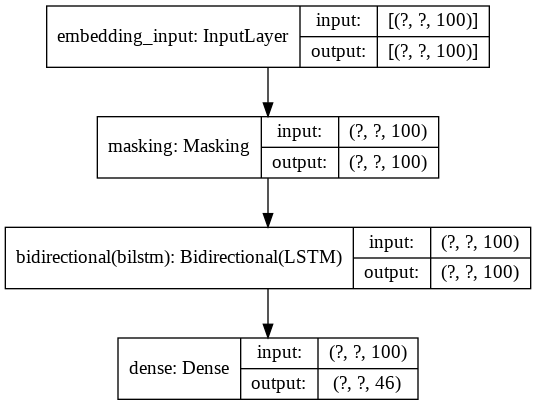

In [ ]:
# Plot the model structure
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Training the Model :

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.7478
Epoch 00001: val_accuracy improved from -inf to 0.84052, saving model to /content/models/bilstm_fc.h5
123/123 [==============================] - 26s 215ms/step - loss: 0.0952 - accuracy: 0.7478 - val_loss: 0.1765 - val_accuracy: 0.8405
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.8933
Epoch 00002: val_accuracy improved from 0.84052 to 0.86153, saving model to /content/models/bilstm_fc.h5
123/123 [==============================] - 24s 197ms/step - loss: 0.0371 - accuracy: 0.8933 - val_loss: 0.1558 - val_accuracy: 0.8615
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9193
Epoch 00003: val_accuracy improved from 0.86153 to 0.87147, saving model to /content/models/bilstm_fc.h5
123/123 [==============================] - 24s 196ms/step - loss: 0.0277 - accuracy: 0.9193 - val_loss: 0.1473 - val_accuracy: 0.871

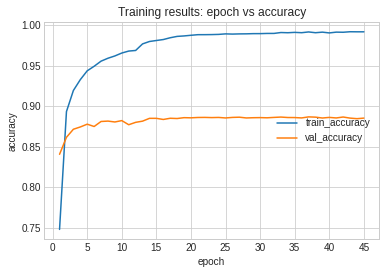

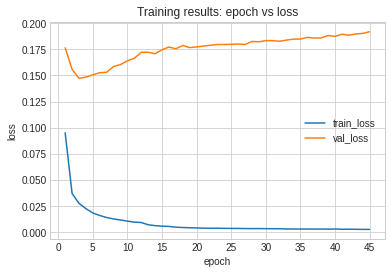

In [ ]:
# folder and model_name are useful because we want to save through callback the best performing model
folder = os.getcwd()
model_name = "bilstm_fc"

history = train_model(folder, model, model_name, X_train, Y_train, X_val, Y_val, btch_size, n_epochs)

WE TRIED BOTH WITH MASKING LAYER AND WITHOUT IT:

WE NOTICED THAT WITHOUT MASKING LAYER VALIDATION ACCURACY ARE HIGHER. WE SUPPOSED IT COULD BE BECAUSE PREDICTION OF PADDING ELEMENTS MIGHT BE EASIER TO GUESS CORRECTLY, THEREFORE WITH MASKING LAYER WE GET LOWER VALIDATION ACCURACY BUT WE BELIEVE IT IS PREFERABLE ANYWAY BECAUSE MORE TRUSTABLE.

### Recalling best Model :

In [ ]:
model_file = os.path.join(os.getcwd(), "models", model_name+".h5")
bilstm_fc = tf.keras.models.load_model(model_file)

'''
Epoch 61/100
123/123 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9978
Epoch 00061: val_accuracy improved from 0.96693 to 0.96736, saving model to /content/models/bilstm_fc.h5
'''
'''
Epoch 39/100
123/123 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9964
Epoch 00039: val_accuracy improved from 0.96539 to 0.96544, saving model to /content/models/bilstm_fc.h5
'''
'''
Epoch 37/100
123/123 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9960
Epoch 00037: val_accuracy improved from 0.96478 to 0.96526, saving model to /content/models/bilstm_fc.h5
'''

'\nEpoch 37/100\n123/123 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9960\nEpoch 00037: val_accuracy improved from 0.96478 to 0.96526, saving model to /content/models/bilstm_fc.h5\n'

### Evaluation over validation set :

In [ ]:
print("best model over val_accuracy is at epoch: ", np.argmax(history.history['val_accuracy'])+1)
print("with score: ", np.max(history.history['val_accuracy']))

best model over val_accuracy is at epoch:  37
with score:  0.8867331743240356


# EXPERIMENT DOING SMALL MODIFICATIONS TO THE MODEL

**Modifications:** experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

**Training and Experiments:** all the experiments must involve only the training and validation sets.

WE WANT TO ANNOVERATE EVERY MODEL'S VALIDATION ACCURACY IN ORDER TO EVENTUALLY DESIGNATE WHICH IS THE BEST MODEL. WE ALSO WANT TO STORE HOW MANY EPOCHS HAD BEEN NEEDED IN ORDER TO OBTAIN THAT RESULT, FOR FURTHER ANALYSIS AND CONSIDERATIONS :


In [ ]:
# Dictionary that will be helpful once we need to confront the evaluations
from collections import OrderedDict
evaluations = OrderedDict()

# storing best Baseline Model's epoch and val_accuracy scoring
evaluations[model_name] = (bilstm_fc, np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])+1)

## Alternative Model: GRU
the model is structured as follow:
- Bidirectional GRU Layer 
- Dense Layer 

### Building the Model :

In [ ]:
# WE USE THE SAME PARAMETERS AS IN THE BASELINE MODEL

def build_model(label, rnn_units=rnn_units, learning_rate=lrn_rate, drop_out=drp_out):

  model = tf.keras.Sequential(name='words_tagging')

  model.add(tf.keras.layers.Input((None, emb_dimension), name='embedding_input'))

  model.add(tf.keras.layers.Masking(mask_value=0.0))

  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_units,
                          return_sequences=True,
                          dropout=drop_out,
                          name='biGRU')))
  
  model.add(tf.keras.layers.Dense(label, activation='softmax', name='dense'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(loss='categorical_crossentropy', metrics="accuracy", optimizer=optimizer)
  
  model.summary()
  
  return model

In [ ]:
model = build_model(len(tag_to_idx))

Model: "words_tagging"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         45600     
_________________________________________________________________
dense (Dense)                (None, None, 46)          4646      
Total params: 50,246
Trainable params: 50,246
Non-trainable params: 0
_________________________________________________________________


### Plotting the Model :

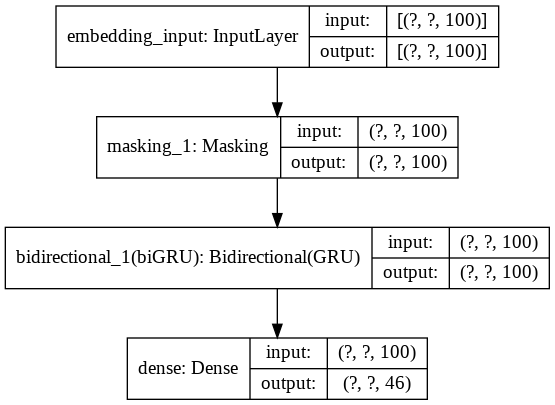

In [ ]:
# Plot the model structure
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Training the Model :

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.7837
Epoch 00001: val_accuracy improved from -inf to 0.85383, saving model to /content/models/bigru_fc.h5
123/123 [==============================] - 26s 208ms/step - loss: 0.0800 - accuracy: 0.7837 - val_loss: 0.1683 - val_accuracy: 0.8538
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9020
Epoch 00002: val_accuracy improved from 0.85383 to 0.86582, saving model to /content/models/bigru_fc.h5
123/123 [==============================] - 23s 189ms/step - loss: 0.0334 - accuracy: 0.9020 - val_loss: 0.1555 - val_accuracy: 0.8658
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9236
Epoch 00003: val_accuracy improved from 0.86582 to 0.86961, saving model to /content/models/bigru_fc.h5
123/123 [==============================] - 23s 189ms/step - loss: 0.0255 - accuracy: 0.9236 - val_loss: 0.1510 - val_accuracy: 0.8696
E

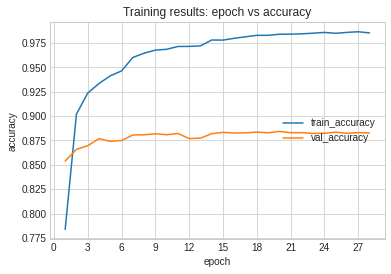

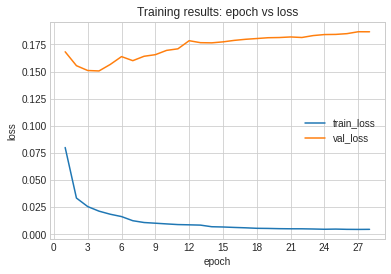

In [ ]:
# folder and model_name are useful because we want to save through callback the best performing model
folder = os.getcwd()
model_name = "bigru_fc"

history = train_model(folder, model, model_name, X_train, Y_train, X_val, Y_val, btch_size, n_epochs)

### Recalling best Model :

In [ ]:
model_file = os.path.join(os.getcwd(), "models", model_name+".h5")
bigru_fc = tf.keras.models.load_model(model_file)

### Evaluation over validation set :

In [ ]:
# storing best Model's epoch and val_accuracy scoring
evaluations[model_name] = (bigru_fc, np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])+1)

## Alternative Model : two LSTM
The model is structured as follow:
- Bidirectional LSTM Layer
- Bidirectional LSTM Layer
- Dense Layer


### Building the Model :

In [ ]:
# WE USE THE SAME PARAMETERS AS IN THE BASELINE MODEL

def build_model(label, rnn_units=rnn_units, learning_rate=lrn_rate, drop_out=drp_out):

  model = tf.keras.Sequential(name='words_tagging')

  model.add(tf.keras.layers.Input((None, emb_dimension), name='embedding_input'))

  model.add(tf.keras.layers.Masking(mask_value=0.0))

  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,
                                                                return_sequences=True,
                                                                dropout=drop_out,
                                                                name='bilstm1'),
                                          merge_mode="concat"))
  
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,
                                                                return_sequences=True,
                                                                dropout=drop_out,
                                                                name='bilstm2'),
                                          merge_mode="concat"))
  
  model.add(tf.keras.layers.Dense(label, activation='softmax', name='dense'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(loss='categorical_crossentropy', metrics="accuracy", optimizer=optimizer)
  
  model.summary()
  
  return model

In [ ]:
model = build_model(len(tag_to_idx))

Model: "words_tagging"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 100)         60400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 100)         60400     
_________________________________________________________________
dense (Dense)                (None, None, 46)          4646      
Total params: 125,446
Trainable params: 125,446
Non-trainable params: 0
_________________________________________________________________


### Plotting the Model :

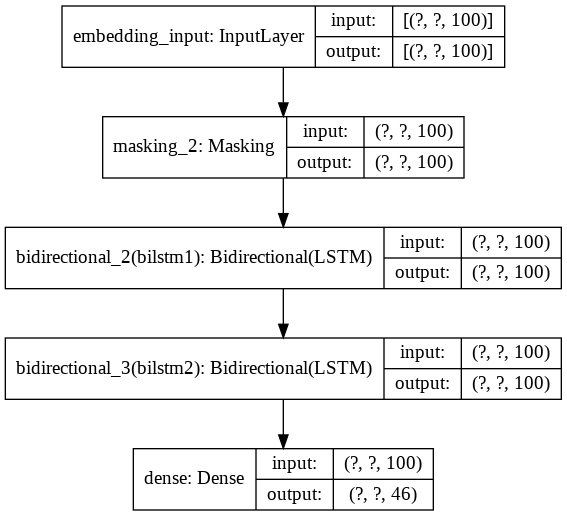

In [ ]:
# Plot the model structure
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Training the Model :

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.6661
Epoch 00001: val_accuracy improved from -inf to 0.83821, saving model to /content/models/doublebilstm_fc.h5
123/123 [==============================] - 58s 472ms/step - loss: 0.1199 - accuracy: 0.6661 - val_loss: 0.1747 - val_accuracy: 0.8382
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.8900
Epoch 00002: val_accuracy improved from 0.83821 to 0.87227, saving model to /content/models/doublebilstm_fc.h5
123/123 [==============================] - 51s 413ms/step - loss: 0.0377 - accuracy: 0.8900 - val_loss: 0.1406 - val_accuracy: 0.8723
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9198
Epoch 00003: val_accuracy improved from 0.87227 to 0.87856, saving model to /content/models/doublebilstm_fc.h5
123/123 [==============================] - 51s 413ms/step - loss: 0.0263 - accuracy: 0.9198 - val_loss: 0.1402 - v

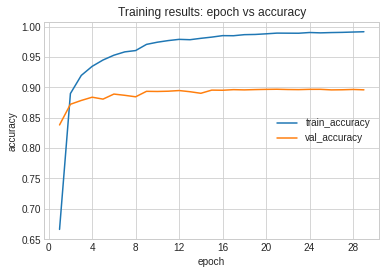

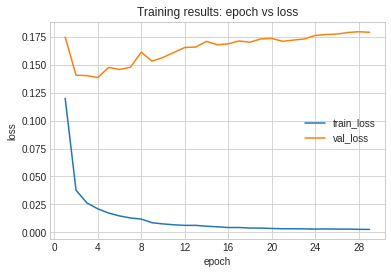

In [ ]:
# folder and model_name are useful because we want to save through callback the best performing model
folder = os.getcwd()
model_name = "doublebilstm_fc"

history = train_model(folder, model, model_name, X_train, Y_train, X_val, Y_val, btch_size, n_epochs)

### Recalling best Model :

In [ ]:
model_file = os.path.join(os.getcwd(), "models", model_name+".h5")
doublebilstm_fc = tf.keras.models.load_model(model_file)

### Evaluation over validation set :

In [ ]:
# storing best Model's epoch and val_accuracy scoring
evaluations[model_name] = (doublebilstm_fc, np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])+1)

## CRF Model :
The model is structure as follow:
- Bidirectional LSTM Layer
- CRF Layer 

### Required modifications :

IN ORDER TO BUILD THIS MODEL, WE USED <b>tf2crf</b> PACKAGE.

THIS PACKAGE ALREADY OVERRIDES SOME OF <b>tensorflow_addons </b> MODULES,
IN PARTICULAR THE <b> tensorflow_addons / layer / crf </b> MODULE IS MODIFIED EXACTLY AS WE NEED IT.

https://pypi.org/project/tf2crf/

https://github.com/tensorflow/addons/tree/master/tensorflow_addons
https://github.com/tensorflow/addons/blob/master/tensorflow_addons/layers/crf.py

HERE IS THE CODE OF THE ADDONS CLASS AND OF tf2crf ONE, CUSTOMIZED AS WE NEED IT :

```
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K


class CRF(tf.keras.layers.Layer):
    """
    Conditional Random Field layer (tf.keras)
    `CRF` can be used as the last layer in a network (as a classifier). Input shape (features)
    must be equal to the number of classes the CRF can predict (a linear layer is recommended).
    Args:
        chain_initializer: the initialize method for transitions, default orthogonal.
    Input shape:
        nD tensor with shape `(batch_size, sentence length, num_classes)`.
    Output shape:
        in training:
            viterbi_sequence: the predicted sequence tags with shape `(batch_size, sentence length)`
            inputs: the input tensor of the CRF layer with shape `(batch_size, sentence length, num_classes)`
            sequence_lengths: true sequence length of inputs with shape `(batch_size)`
            self.transitions: the internal transition parameters of CRF with shape `(num_classes, num_classes)`
        in predicting:
            viterbi_sequence: the predicted sequence tags with shape `(batch_size, sentence length)`
    Masking
        This layer supports keras masking for input data with a variable number
        of timesteps. To introduce masks to your data,
        use an embedding layer with the `mask_zero` parameter
        set to `True` or add a Masking Layer before this Layer
    """

    def __init__(self, chain_initializer="orthogonal", **kwargs):
        super(CRF, self).__init__(**kwargs)
        self.chain_initializer = tf.keras.initializers.get(chain_initializer)
        self.transitions = None
        self.supports_masking = True
        self.mask = None
        self.accuracy_fn = tf.keras.metrics.Accuracy()

    def get_config(self):
        config = super(CRF, self).get_config()
        config.update({"chain_initializer": "orthogonal"})
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3
        units = input_shape[-1]
        self.transitions = self.add_weight(
            name="transitions",
            shape=[units, units],
            initializer=self.chain_initializer,
        )

    def call(self, inputs, mask=None, training=None):
        if mask is None:
            raw_input_shape = tf.slice(tf.shape(inputs), [0], [2])
            mask = tf.ones(raw_input_shape)
        sequence_lengths = K.sum(K.cast(mask, 'int32'), axis=-1)
        viterbi_sequence, _ = tfa.text.crf_decode(inputs, self.transitions, sequence_lengths)
        return viterbi_sequence, inputs, sequence_lengths, self.transitions
```

```
from tensorflow.keras.models import Model
from tf2crf import CRF, ModelWithCRFLoss


class ModelWithCRFLoss(tf.keras.Model):

    def __init__(self, base_model, use_dsc=False):
        super().__init__()
        self.base_model = base_model
        self.accuracy_fn = tf.keras.metrics.Accuracy(name='accuracy')

    def call(self, inputs):
        return self.base_model(inputs)

    def compute_loss(self, x, y, sample_weight, training=False):
        y_pred = self(x, training=training)
        viterbi_sequence, potentials, sequence_length, chain_kernel = y_pred
        # we now add the CRF loss:
        crf_loss = -crf_log_likelihood(potentials, y, sequence_length, chain_kernel)[0]
        if sample_weight is not None:
            crf_loss = crf_loss * sample_weight
        return viterbi_sequence, sequence_length, tf.reduce_mean(crf_loss)

    def accuracy(self, y_true, y_pred):
        viterbi_sequence, potentials, sequence_length, chain_kernel = y_pred
        sample_weights = tf.sequence_mask(sequence_length, y_true.shape[1])
        return self.accuracy_fn(y_true, viterbi_sequence, sample_weights)

    def train_step(self, data):
        x, y, sample_weight = unpack_data(data)
        with tf.GradientTape() as tape:
            viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, sample_weight, training=True)
        gradients = tape.gradient(crf_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.accuracy_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
        return {"crf_loss": crf_loss, 'accuracy': self.accuracy_fn.result()}

    def test_step(self, data):
        x, y, sample_weight = unpack_data(data)
        viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, sample_weight)
        self.accuracy_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
        return {"crf_loss_val": crf_loss, 'val_accuracy': self.accuracy_fn.result()}
```

IN ORDER TO USE CALLBACKS FOR THIS MODEL, WE NEEDED TO CHANGE MONITOR PARAMENTER BECAUSE THE MODULE WE USED ASSIGNS NAMES DIFFERENTLY TO THE METRICS :

In [ ]:
# NAME FOR TRAIN LOSS : crf_loss
# NAME FOR TRAIN ACCURACY : accuracy
# NAME FOR VALIDATION LOSS : val_crf_loss_val
# NAME FOR VALIDATION ACCURACY : val_val_accuracy

import tensorflow as tf

def draw_graphs(history):

    epochs = len(history['crf_loss'])
    x = np.arange(0, epochs) + 1

    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs accuracy")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.plot(x, history['accuracy'])
    ax1.plot(x, history['val_val_accuracy'])
    ax1.legend(['train_accuracy', 'val_accuracy'], loc='center right')
    ax1.tick_params(axis='y')

    plt.show()


    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs loss")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(x, history['crf_loss'])
    ax1.plot(x, history['val_crf_loss_val'])
    ax1.legend(['train_loss', 'val_loss'], loc='center right')
    ax1.tick_params(axis='y')
    
    plt.show()
    

In [ ]:
# NAME FOR VALIDATION LOSS : val_crf_loss_val
# NAME FOR VALIDATION ACCURACY : val_val_accuracy

def train_model(folder, model, model_name, X_train, Y_train, X_val, Y_val, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_val_accuracy', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_val_accuracy', 
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_val_accuracy',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
  
  history = model.fit(X_train, Y_train,
    epochs=epochs,
    batch_size=batch,
    validation_data = (X_val, Y_val),
    callbacks=[model_callback, early_stopping_callback, reduce_lr_callback]
    )

  draw_graphs(history.history)

  return history

IN ORDER TO USE THIS MODEL, WE ALSO NEEDED TO CHANGE THE SHAPE OF OUR Y OUTPUTS. SINCE IT NEEDS TO BE OF TWO-DIMENSION SHAPE, WE DECIDED TO NOT ONE-HOT-ENCODE THE TAGS AND INSTEAD WE WENT FOR A INTEGER CODIFICATION OF THE TAGS THROUGH THE <b>tag_to_idx</b> DICTIONARY :

In [ ]:
def convert_data_CRF(df, word_to_emb, tag_to_idx):
  new_rows = [] # rows of the new to-return dataframe
  for row in df.iterrows():
    # substitute words with its embeddings
    words = [word_to_emb[w] for w in row[1][0]]
    # substitute tags with its one-hot-encoding
    tags = []
    for t in row[1][1]:
        tags.append(tag_to_idx[t])
    # row for the new encoded dataframe
    new_row = {
        'embeddings' : words,
        'tags' : tags
    }
    new_rows.append(new_row)

  # transform the list of rows in a proper dataframe
  df = pd.DataFrame(new_rows)
  df = df[["embeddings", "tags"]]

  return df


df_trainENC_CRF = convert_data_CRF(df_train, word_to_emb_train, tag_to_idx)
df_valENC_CRF = convert_data_CRF(df_val, word_to_emb_val, tag_to_idx)
df_testENC_CRF = convert_data_CRF(df_test, word_to_emb_test, tag_to_idx)

In [ ]:
print("USUAL Y_train.shape:", Y_train.shape)
Y_train_CRF = tf.keras.preprocessing.sequence.pad_sequences(
           df_trainENC_CRF['tags'].tolist(),
           padding = 'post', value=tag_to_idx['PAD'])
print("CRF CONVERTION: Y_train_CRF.shape: {}\n".format(Y_train_CRF.shape))

print("USUAL Y_val.shape:", Y_val.shape)
Y_val_CRF = tf.keras.preprocessing.sequence.pad_sequences(
           df_valENC_CRF['tags'].tolist(),
           padding = 'post', value=tag_to_idx['PAD'])
print("CRF CONVERTION: Y_val_CRF.shape: {}\n".format(Y_val_CRF.shape))

print("USUAL Y_test.shape:", Y_test.shape)
Y_test_CRF = tf.keras.preprocessing.sequence.pad_sequences(
           df_testENC_CRF['tags'].tolist(),
           padding = 'post', value=tag_to_idx['PAD'])
print("CRF CONVERTION: Y_test_CRF.shape: {}\n".format(Y_test_CRF.shape))

USUAL Y_train.shape: (1963, 249, 46)
CRF CONVERTION: Y_train_CRF.shape: (1963, 249)

USUAL Y_val.shape: (1299, 81, 46)
CRF CONVERTION: Y_val_CRF.shape: (1299, 81)

USUAL Y_test.shape: (49, 1492, 46)
CRF CONVERTION: Y_test_CRF.shape: (49, 1492)



### Building the Model :

In [ ]:
!pip install tf2crf

from tensorflow.keras.models import Model
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
# WE USE THE SAME PARAMETERS AS IN THE BASELINE MODEL

def build_model(label, rnn_units=rnn_units, learning_rate=lrn_rate, drop_out=drp_out):

  inputs = tf.keras.layers.Input((None, emb_dimension), name='input')

  #output = tf.keras.layers.Masking(mask_value=0.0)(input)
  
  output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,
                                                                  return_sequences=True,
                                                                  dropout=drop_out,
                                                                  name='bilstm'),
                                            merge_mode="concat")(inputs) #(output) # if masking works...
  
  crf = CRF(dtype='float32', name='CRF')
  
  output = crf(output)
  
  base_model = Model(inputs, output)
  
  model = ModelWithCRFLoss(base_model)
  
  model.compile(optimizer='adam')

  base_model.summary() # we can ask only for base_model summary
  
  return model

In [ ]:
model = build_model(len(tag_to_idx))

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 100)]       0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 100)         60400     
_________________________________________________________________
CRF (CRF)                    ((None, None), (None, Non 10002     
Total params: 70,402
Trainable params: 70,400
Non-trainable params: 2
_________________________________________________________________


### Plotting the Model :

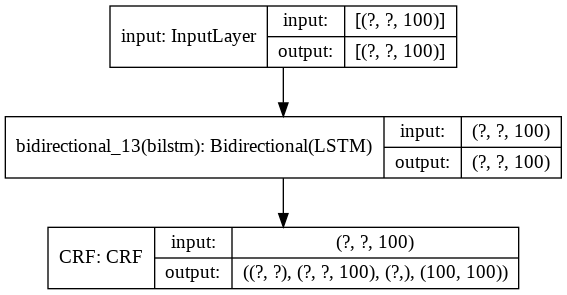

In [ ]:
# Plot the model structure
tf.keras.utils.plot_model(model.base_model, show_shapes=True, show_layer_names=True)

### Training the Model :

Epoch 1/50
123/123 [==============================] - ETA: 0s - crf_loss: 887.1473 - accuracy: 0.5368
Epoch 00001: val_val_accuracy improved from -inf to 0.73664, saving model to /content/models/bilstm_crf.h5
123/123 [==============================] - 63s 511ms/step - crf_loss: 885.8665 - accuracy: 0.5368 - val_crf_loss_val: 244.1414 - val_val_accuracy: 0.7366
Epoch 2/50
123/123 [==============================] - ETA: 0s - crf_loss: 645.8290 - accuracy: 0.9180
Epoch 00002: val_val_accuracy improved from 0.73664 to 0.75018, saving model to /content/models/bilstm_crf.h5
123/123 [==============================] - 62s 504ms/step - crf_loss: 645.3880 - accuracy: 0.9180 - val_crf_loss_val: 201.2552 - val_val_accuracy: 0.7502
Epoch 3/50
123/123 [==============================] - ETA: 0s - crf_loss: 560.3542 - accuracy: 0.9294
Epoch 00003: val_val_accuracy improved from 0.75018 to 0.78738, saving model to /content/models/bilstm_crf.h5
123/123 [==============================] - 62s 501ms/step -

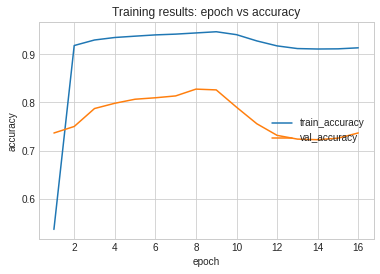

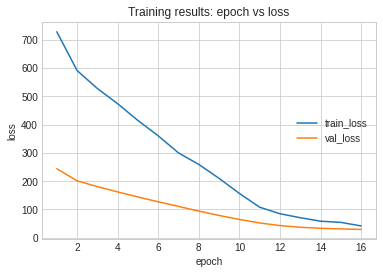

In [ ]:
# folder and model_name are useful because we want to save through callback the best performing model
folder = os.getcwd()
model_name = "bilstm_crf"

history = train_model(folder, model, model_name, X_train, Y_train_CRF, X_val, Y_val_CRF, btch_size, n_epochs)

### Recalling best Model :

In [ ]:
model_file = os.path.join(os.getcwd(), "models", model_name+".h5")

#bilstm_crf = tf.keras.models.load_model(model_file)
bilstm_crf = model # because we want the same structure...
bilstm_crf.load_weights(model_file) # ...with the best (saved) weights

### Evaluation over validation set :

In [ ]:
# storing best Model's epoch and val_accuracy scoring
evaluations[model_name] = (bilstm_crf, np.max((history.history['val_val_accuracy'])), np.argmax(history.history['val_val_accuracy'])+1)

In [ ]:

# Y_pred = [viterbi_sequence, inputs, sequence_lengths, self.transitions]
prediction = bilstm_crf.call(X_test)

Y_pred = prediction[0]
#inputs = prediction[1] 
#sequence_lengths = prediction[2] 
#transitions = prediction[3] 

In [ ]:
def tagsfromints(Y, idx_to_tag):
  integers = []
  Y = Y.numpy()
  for el in Y:
    integers.append([idx_to_tag[i] for i in el])
  return integers


pred_tags = tagsfromints(Y_pred, idx_to_tag)

# EVALUATE YOUR BEST MODEL

**Evaluation:** in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

* The metric you must use to evaluate your final model is the F1-macro, without considering punctuation/symbols classes. During the training process, you can't use the F1 metric unless you use a single (gigantic) batch: there is no way to aggregate "partial" F1 scores computed on mini-batches. So, during the training process, it is common practice to use accuracy. It is actually possible to define the computation of F1 scores by hand but it can be tricky, it will not be optimized, and most of the time it won't make a difference, so don't.
* Evaluation: make sure you ignore predictions corresponding to padding inputs, otherwise your evaluation is incorrect! If you want to compute padding-aware metrics during training, you need to define custom Keras callbacks (if you are using Keras). For more information, check the following documentation page: https://www.tensorflow.org/guide/keras/custom_callback.


In [ ]:
for key in evaluations.keys():
  print("MODEL {} :\nvalidation accuracy of {}\nafter {} epochs\n\n".format(key, evaluations[key][1], evaluations[key][2]))

MODEL bilstm_fc :
validation accuracy of 0.8867331743240356
after 37 epochs


MODEL bigru_fc :
validation accuracy of 0.8842638731002808
after 20 epochs


MODEL doublebilstm_fc :
validation accuracy of 0.8970272541046143
after 21 epochs


MODEL bilstm_crf :
validation accuracy of 0.8276166915893555
after 8 epochs




WE CHOOSE BEST MODEL DEPENDING ON HIGHEST ACCURACY OVER THE VALIDATION SET :

In [ ]:
best_val_acc = np.argmax([val_acc for m, val_acc, e in evaluations.values()])
best_model_name = list(evaluations.keys())[best_val_acc]
best_model = evaluations[best_model_name][0]

<i> The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter. </i> 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

```
sklearn.metrics.f1_score(y_true, y_pred, *,
        labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
```

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean.
This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support
(the number of true instances for each label).
This alters ‘macro’ to account for label imbalance;
it can result in an F-score that is not between precision and recall.

WE NOW COMPUTE EVALUATION OF THE BEST MODEL THROUGH F1-SCORE :

In [ ]:
from sklearn.metrics import f1_score

if best_model_name == 'bilstm_crf':
  Y_pred = best_model.call(X_test)
  Y_pred_toidx = Y_pred.ravel()
  Y_true_toidx = Y_true_CRF.ravel()
else:
  Y_pred = best_model.predict(X_test)
  Y_pred_toidx = np.argmax(Y_pred, axis=2)
  Y_pred_toidx = Y_pred_toidx.ravel()
  Y_true_toidx = np.argmax(Y_test, axis=2)
  Y_true_toidx = Y_true_toidx.ravel()

ls = [i for t, i in tag_to_idx.items() if t not in [',', '.', '$', ':', '``', "''", '#', 'PAD']]
score_macro = f1_score(Y_true_toidx, Y_pred_toidx, labels=ls, zero_division=0, average='macro')
#score_micro = f1_score(Y_true_toidx, Y_pred_toidx, labels=ls, average='micro')
#score_weighted = f1_score(Y_true_toidx, Y_pred_toidx, labels=ls, average='weighted')

print("Best model (depending on validation accuracy) is : {}\nIt gets F1-score(macro) over test set of {:.2f}%".format(best_model_name, score_macro));

Best model (depending on validation accuracy) is : doublebilstm_fc
It gets F1-score(macro) over test set of 0.68%


# ANALYZE THE ERRORS OF YOUR MODEL (optional)

**Error Analysis:** analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

WE TRIED FOR THE MODELS BOTH WITH MASKING LAYER AND WITHOUT IT:

WE NOTICED THAT WITHOUT MASKING LAYER VALIDATION ACCURACY ARE HIGHER. WE SUPPOSED IT COULD BE BECAUSE PREDICTION OF PADDING ELEMENTS MIGHT BE EASIER TO GUESS CORRECTLY, THEREFORE WITH MASKING LAYER WE GET LOWER VALIDATION ACCURACY BUT WE BELIEVE IT IS PREFERABLE ANYWAY BECAUSE MORE TRUSTABLE.

### Some experiments :

In [ ]:
def tag_sentence(sentence, model, idx_to_tag):
  input = np.expand_dims(sentence, axis=0) # to fit the input to model's input's shape
  output = model.predict(input)
  idxs_tag = np.argmax(output, axis=2)[0] # to get rid of useless dimension
  tags = []
  for i in idxs_tag:
    tag = idx_to_tag[i]
    if tag != idx_to_tag[0]:
      tags.append(tag)
  return tags


def tag_word(word, model, idx_to_tag):
  input = np.expand_dims(word, axis=0) # to fit the input to model's input's shape
  input = np.expand_dims(input, axis=0) # to fit the input to model's input's shape
  output = model.predict(input)
  idx_tag = np.argmax(output, axis=2)[0][0] # to get rid of useless dimension
  tag = idx_to_tag[idx_tag]
  return tag


In [ ]:
idx_w = (4, 11)
idx_s = 2

word = df_test['text'][idx_w[0]][idx_w[1]]
word_emb = X_test[idx_w[0]][idx_w[1]]
sentence = df_test['text'][idx_s]
sentence_emb = X_test[idx_s]


print(word)
print("Predicted tag:\t", tag_word(word_emb, best_model, idx_to_tag))
print("True tag:\t", idx_to_tag[np.argmax(Y_test[idx_w[0]][idx_w[1]])])
print()
print()

print(' '.join(sentence))
print("Predicted tag:\t", ' '.join(tag_sentence(sentence_emb, best_model, idx_to_tag)))
print("True tag:\t", ' '.join([idx_to_tag[idx] for idx in np.argmax(Y_test[idx_s], axis=1)]))

major
Predicted tag:	 JJ
True tag:	 JJ


Intelogic Trace Inc. , San Antonio , Texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million . The move boosts Intelogic Chairman Asher Edelman 's stake to 20 % from 16.2 % and may help prevent Martin Ackerman from making a run at the computer-services concern . Mr. Ackerman already is seeking to oust Mr. Edelman as chairman of Datapoint Corp. , an Intelogic affiliate . The action followed by one day an Intelogic announcement that it will retain an investment banker to explore alternatives `` to maximize shareholder value , '' including the possible sale of the company . In New York Stock Exchange composite trading yesterday , Intelogic shares rose 37.5 cents to close at $ 2.75 . Mr. Edelman declined to specify what prompted the recent moves , saying they are meant only to benefit shareholders when `` the company is on a roll . '' He added , `` This h

AT SOME POINT, WE GOT THIS EXAMPLE:

"Intelogic Trace Inc. , San Antonio , Texas , said it bought 2.7 million shares , or **about** 18 % , of [...]"

<i>Predicted tag:	 NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC **RB** CD NN , IN </i>[...]

<i>True tag:	 NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC **IN** CD NN , IN </i>[...]

WE CAN SEE THAT "about" GETS MISTAKEN...

WE HAD A LOOK TO **'RB'** AND **'IN'** TAGGING:

In [ ]:
print(df_w.loc[df_w['tag']=='RB', 'word'].head())
print(df_w.loc[df_w['tag']=='IN', 'word'].head())

22      too
29      far
60     also
103    well
217     n't
Name: word, dtype: object
5      out
6       of
9      for
18    that
30      in
Name: word, dtype: object


HONESTLY... WE ARE NOT SO SURE OUR MODEL IS MISTAKING! ;)